# 📊 Trabajo integrador - Modelado y Evaluación
Grupo 19- Sanz Rodrigo, Rodriguez Paula

---


# Introducción y objetivos
**Problema:** A partir de un conjunto de avisos laborales extraídos del portal Computrabajo, se busca construir un modelo que permita predecir el tipo de puesto laboral en función de las habilidades que se mencionan en cada aviso.



**Objetivo predictivo:**

- **Variable objetivo (`y`)**: tipo de puesto laboral (etiquetado unificado).
- **Variables predictoras (`X`)**: conjunto de columnas binarias correspondientes a las habilidades
- **Tipo de problema**: clasificación supervisada.



**Objetivo General:** Desarrollar un modelo de clasificación supervisada que, dadas las habilidades requeridas en un aviso (por ejemplo: `Python`, `Excel`, `HTML`, `SQL`, etc.), prediga el puesto laboral correspondiente dentro de un conjunto de categorías previamente unificadas.

---


# Preparación de los datos

Carga correcta
Dimensiones: (473, 75)

Columnas (primeras 20): ['categoria', 'titulo_puesto', 'empresa', 'ubicacion', 'modalidad', 'salario', 'fecha_publicacion', 'tipo_contrato', 'jornada', 'palabras_clave', 'url', 'educacion_minima', 'anios_experiencia', 'edad_min', 'edad_max', 'licencia_conducir', 'python', 'java', 'javascript', 'typescript'] ...


,categoria,titulo_puesto,empresa,ubicacion,modalidad,salario,fecha_publicacion,tipo_contrato,jornada,palabras_clave,...,soft_trabajo_en_equipo,soft_resol_problemas,soft_adaptabilidad,soft_cap_analitica,soft_autonomia,soft_organizacion,soft_proactividad,soft_responsabilidad,soft_liderazgo,clase_general
0,Informatica y telecom,Analista de Sistemas,Adn - Recursos Humanos,Buenos Aires-GBA,No define,500K,2025-10-09,Contrato por tiempo indeterminado,Jornada completa,"analyst, system",...,0,0,0,0,0,1,0,0,0,Analista / Gestión
1,Desarrollador,Analista de Diseño Web,Morales Marina Julieta,Buenos Aires-GBA,No define,1.5M,2025-10-09,Contrato por tiempo indeterminado,Jornada completa,"analyst, internet, web",...,0,0,1,0,0,0,0,0,0,Analista / Gestión
2,Datos,Responsable de Administración y Cobranzas de C...,Adn - Recursos Humanos,Buenos Aires-GBA,Presencial y remoto,500K,2025-10-09,Contrato por tiempo indeterminado,Jornada completa,"residente, encargado, supervisor, subgerente, ...",...,0,0,0,0,0,1,0,0,1,No Pertenece a IT
3,Datos,Responsable de administración de Consorcios y ...,Adn - Recursos Humanos,Buenos Aires-GBA,Presencial y remoto,500K,2025-10-09,Contrato por tiempo indeterminado,Jornada completa,"residente, encargado, supervisor, subgerente, ...",...,0,0,0,0,0,1,0,0,1,No Pertenece a IT
4,Datos,Contador,Adn - Recursos Humanos,Buenos Aires-GBA,Presencial y remoto,500K,2025-10-09,Contrato por tiempo indeterminado,Jornada completa,"pagador, contralor, accountant, facturista, te...",...,0,0,0,0,0,1,0,0,1,No Pertenece a IT



Distribución de clases:


clase_general
Analista / Gestión                       92
Datos / BI                               11
Desarrollador                            82
Infraestructura / DevOps / Seguridad     25
No Pertenece a IT                       180
QA / Testing                             16
Tecnico / Soporte                        61
UX / Diseño                               6
Name: count, dtype: int64

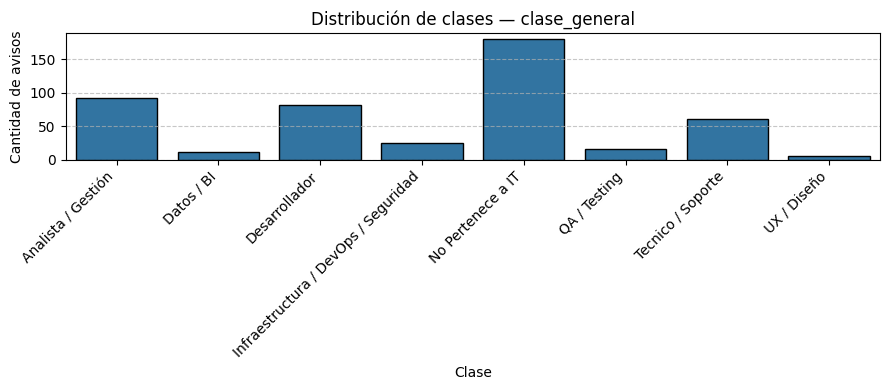

In [1]:
# ============================================
# BLOQUE 1 — Carga y revisión (un solo CSV)
# ============================================
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#!gdown --fuzzy "https://drive.google.com/file/d/12X-LmjUhjKaBjiywGIcfJw4Jpzt8eRxc/view?usp=sharing"

# --- Ruta del CSV único ---
#data_path = "/content/computrabajo_full.csv"

# --- Carga ---
df = pd.read_csv('computrabajo_2025-10-17_limpio_full.csv')

# --- Columna objetivo (target) ---
TARGET_COL = "clase_general"
assert TARGET_COL in df.columns, f"Falta la columna target '{TARGET_COL}' en el CSV."

# --- Resumen básico ---
print("Carga correcta")
print("Dimensiones:", df.shape)
print("\nColumnas (primeras 20):", list(df.columns)[:20], "...")
display(df.head())

# --- Distribución de la variable objetivo ---
dist = df[TARGET_COL].value_counts().sort_index()
print("\nDistribución de clases:")
display(dist)

# --- Gráfico de distribución (alineado) ---
plt.figure(figsize=(9,4))
sns.countplot(
    data=df,
    x=TARGET_COL,
    order=sorted(df[TARGET_COL].unique()),
    edgecolor="black"
)
plt.title("Distribución de clases — clase_general")
plt.xlabel("Clase")
plt.ylabel("Cantidad de avisos")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()





Distribución de clases unificadas:


,count
clase_unificada,
No pertenece a IT,222
Desarrollo / Programación,75
Analisis / Gestion de proyectos,64
Soporte Técnico,61
Infraestructura / Seguridad,24
QA / Testing,14
Datos / BI,7
UX / Diseño,6


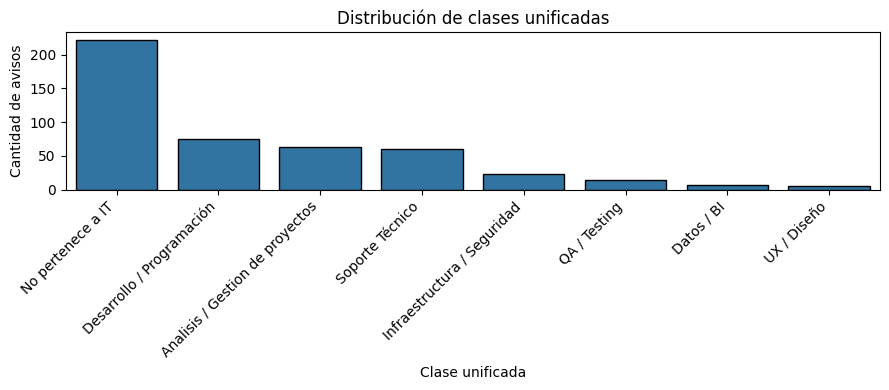

In [ ]:
# ============================================
# BLOQUE 2 — Unificación de clases similares
# ============================================

mapeo_clases = {

    # Infraestructura y seguridad
    "Infraestructura / DevOps": "Infraestructura / Seguridad",
    "Seguridad": "Infraestructura / Seguridad",

    # Tecnico y soporte
    "Tecnico": "Soporte Técnico",
    "Soporte técnico": "Soporte Técnico",

    #Desarrolladores
    "Desarrollo Backend":"Desarrollo / Programación",
    "Desarrollo Frontend": "Desarrollo / Programación",
    "Desarrollo Fullstack": "Desarrollo / Programación",
    "Developer": "Desarrollo / Programación",

    #Analista y gestion de proyectos
    "Analista": "Analisis / Gestion de proyectos",
    "Gestión de proyectos": "Analisis / Gestion de proyectos"

}

df["clase_unificada"] = df["clase_general"].replace(mapeo_clases)

# Verificar resultado
print("\nDistribución de clases unificadas:")
display(df["clase_unificada"].value_counts())

plt.figure(figsize=(9,4))
sns.countplot(
    data=df,
    x="clase_unificada",
    order=df["clase_unificada"].value_counts().index,
    edgecolor="black"
)
plt.title("Distribución de clases unificadas")
plt.xlabel("Clase unificada")
plt.ylabel("Cantidad de avisos")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


**Conclusión:**

Se cargó el dataset computrabajo_full.csv, con un total de 473 filas y 75 columnas.
La variable objetivo es clase_general, que agrupa los roles laborales en ocho categorías principales.
La distribución de clases muestra que la mayoría de los avisos corresponden a “No pertenece a IT”, mientras que las demás clases están presentes en proporciones más equilibradas que en versiones anteriores del dataset.

# Definición de features y estratificado

In [2]:
# ============================================
# BLOQUE 3 — Definir features (X) y target (y)
# ============================================

# Variable objetivo
TARGET_COL = "clase_general"

# --- Lista blanca de columnas de skills (binarias 0/1) ---
skills_cols = [
    # Lenguajes de programación
    "python","java","javascript","typescript","php","r","sql","c++",
    # Frontend / diseño
    "html","css","react","angular","vue","figma",
    # Frameworks / entornos
    "spring",".net",
    # Bases de datos
    "mysql","postgresql","oracle","mongodb","nosql",
    # Infraestructura y DevOps
    "docker","kubernetes","aws","azure","gcp","jenkins","ci_cd","linux","hardware","redes",
    # Control de versiones / herramientas
    "git","jira","confluence",
    # BI / análisis
    "excel","power_bi","tableau","sap","google_analytics",
    # Metodologías
    "scrum","kanban","agile",
    # Soft skills (si existen)
    "soft_comunicacion","soft_trabajo_en_equipo","soft_resol_problemas",
    "soft_adaptabilidad","soft_cap_analitica","soft_autonomia",
    "soft_organizacion","soft_proactividad","soft_responsabilidad","soft_liderazgo"
]

# Filtramos solo las columnas que existan realmente en el dataset
skills_cols = [c for c in skills_cols if c in df.columns]

print(f"Columnas de skills seleccionadas: {len(skills_cols)}")
print(skills_cols[:10], "...")

# --- Definir X e y ---
X = df[skills_cols].fillna(0).astype(float)
y = df[TARGET_COL].astype("category")

print("Shapes -> X:", X.shape, "| y:", y.shape)
print("Clases objetivo:", list(y.cat.categories))


Columnas de skills seleccionadas: 52
['python', 'java', 'javascript', 'typescript', 'php', 'r', 'sql', 'c++', 'html', 'css'] ...
Shapes -> X: (473, 52) | y: (473,)
Clases objetivo: ['Analista / Gestión', 'Datos / BI', 'Desarrollador', 'Infraestructura / DevOps / Seguridad', 'No Pertenece a IT', 'QA / Testing', 'Tecnico / Soporte', 'UX / Diseño']


In [3]:
# ============================================
# BLOQUE 4 — División del dataset (Holdout 80/20)
# ============================================
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

# División estratificada: 80% entrenamiento + 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Shapes:")
print("  X_train:", X_train.shape, "| y_train:", y_train.shape)
print("  X_test :", X_test.shape, "| y_test :", y_test.shape)

print("\nDistribución de clases (train):")
display(y_train.value_counts(normalize=True).round(3))

print("\nDistribución de clases (test):")
display(y_test.value_counts(normalize=True).round(3))


Shapes:
  X_train: (378, 52) | y_train: (378,)
  X_test : (95, 52) | y_test : (95,)

Distribución de clases (train):


clase_general
No Pertenece a IT                       0.381
Analista / Gestión                      0.193
Desarrollador                           0.172
Tecnico / Soporte                       0.130
Infraestructura / DevOps / Seguridad    0.053
QA / Testing                            0.034
Datos / BI                              0.024
UX / Diseño                             0.013
Name: proportion, dtype: float64


Distribución de clases (test):


clase_general
No Pertenece a IT                       0.379
Analista / Gestión                      0.200
Desarrollador                           0.179
Tecnico / Soporte                       0.126
Infraestructura / DevOps / Seguridad    0.053
QA / Testing                            0.032
Datos / BI                              0.021
UX / Diseño                             0.011
Name: proportion, dtype: float64

El conjunto de datos se dividió en 80% para entrenamiento y 20% para test, utilizando división estratificada (stratify=y) para mantener las proporciones de clases.
Verificamos que la distribución de clases en ambos subconjuntos se conserva estable, garantizando que la evaluación del modelo sea representativa y sin sesgo por desbalance.
Esta configuración es la que utilizaremos como base para todos los experimentos posteriores.

# Pipeline de modelado y comparación de modelos base

In [4]:
# ============================================
# BLOQUE 5 — Pipelines y comparación de modelos base (CV interna)
# (LogisticRegression, LinearSVC, GradientBoosting)
# ============================================
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd

# 1) Elegir k para la CV según la clase menos frecuente (evita errores)
min_count = y_train.value_counts().min()
cv_k = max(3, min(5, int(min_count)))   # entre 3 y 5 típico
print(f"CV estratificada k={cv_k} (mín. por clase en train: {min_count})")

# 2) Métricas
scoring = {
    "accuracy": "accuracy",
    "f1_macro": make_scorer(f1_score, average="macro")
}

# 3) Tres pipelines (features ya son binarias; sin scaler)
pipelines = {
    "LogisticRegression": Pipeline([
        ("clf", LogisticRegression(max_iter=2000, random_state=42))
    ]),
    "LinearSVC": Pipeline([
        ("clf", LinearSVC(random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ("clf", GradientBoostingClassifier(
            random_state=42,
            # hiperparámetros base razonables para empezar:
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,        # profundidad de los árboles base
            subsample=0.8       # un poco de “stochastic” para robustez
        ))
    ]),
}

# 4) Validación cruzada
resultados = []
for nombre, pipe in pipelines.items():
    cv = cross_validate(
        pipe, X_train, y_train,
        cv=cv_k, scoring=scoring, n_jobs=-1, return_train_score=False
    )
    resultados.append({
        "Modelo": nombre,
        "Accuracy (mean)": cv["test_accuracy"].mean(),
        "Accuracy (std)":  cv["test_accuracy"].std(),
        "F1_macro (mean)": cv["test_f1_macro"].mean(),
        "F1_macro (std)":  cv["test_f1_macro"].std()
    })

df_cv = pd.DataFrame(resultados).sort_values("F1_macro (mean)", ascending=False)
print("Resultados CV (k-fold):")
display(df_cv)



CV estratificada k=5 (mín. por clase en train: 5)
Resultados CV (k-fold):


,Modelo,Accuracy (mean),Accuracy (std),F1_macro (mean),F1_macro (std)
2,GradientBoosting,0.492316,0.054696,0.305885,0.051635
1,LinearSVC,0.497579,0.049172,0.300347,0.038694
0,LogisticRegression,0.513544,0.053553,0.296880,0.054890


Se implementaron tres modelos base dentro de un pipeline de Scikit-learn:

* Logistic Regression
* LinearSVC
* Gradient Boosting Classifier

Los modelos se evaluaron con validación cruzada (k-fold estratificada, k=5), midiendo Accuracy y F1-macro.
Los resultados mostraron desempeños similares entre los tres, con F1-macro promedio entre 0.29 y 0.31, siendo el LinearSVC el que obtuvo las mejores métricas iniciales.

# Ajuste de hiperparámetros y evaluación final

CV interna con balanceo: k=5 (mín. por clase: 5)

Mejores hiperparámetros (best_params_):
{'clf__C': 0.1}

Mejor F1-macro (CV):
nan

=== Evaluation on TEST (20%) — Modelo balanceado ===
Accuracy (test): 0.2947
F1-macro (test): 0.2421

Classification report (test):
                                      precision    recall  f1-score   support

                  Analista / Gestión      0.286     0.105     0.154        19
                          Datos / BI      0.059     0.500     0.105         2
                       Desarrollador      0.625     0.294     0.400        17
Infraestructura / DevOps / Seguridad      0.111     0.200     0.143         5
                   No Pertenece a IT      0.611     0.306     0.407        36
                        QA / Testing      0.250     0.667     0.364         3
                   Tecnico / Soporte      0.286     0.500     0.364        12
                         UX / Diseño      0.000     0.000     0.000         1

                            acc

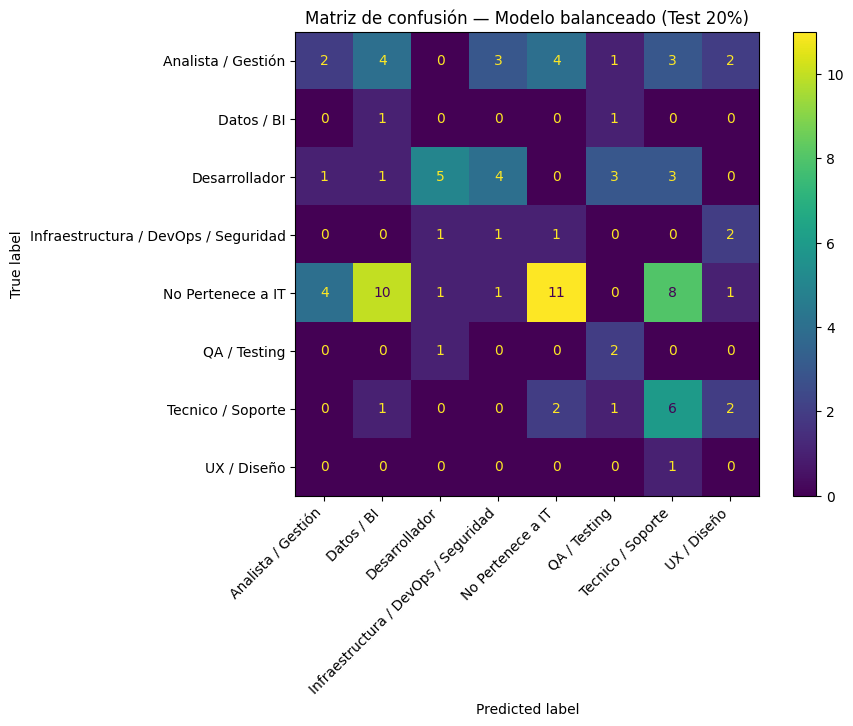


=== Diagnóstico breve ===
F1-macro CV (promedio k-fold): nan
F1-macro Test (holdout 20%) : 0.2421
- CV y Test consistentes; modelo con balanceo más equitativo entre clases.


In [5]:
# ===================================================
# BLOQUE 6 — GridSearchCV para LogisticRegression
# ===================================================
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    f1_score, accuracy_score, make_scorer
)
import matplotlib.pyplot as plt

RANDOM_STATE = 42

# 1) CV interna
min_count = y_train.value_counts().min()
cv_k = max(3, min(5, int(min_count)))
print(f"CV interna con balanceo: k={cv_k} (mín. por clase: {min_count})")

# 2) Pipeline + grilla
pipe_bal = Pipeline([
    ("clf", LogisticRegression(
        max_iter=2000,
        solver="lbfgs",
        class_weight="balanced",  # forzamos balanceo
        random_state=RANDOM_STATE
    ))
])

param_grid_bal = {
    "clf__C": [0.1, 0.2, 0.5, 1.0, 2.0, 3.0]
}

grid_bal = GridSearchCV(
    estimator=pipe_bal,
    param_grid=param_grid_bal,
    cv=cv_k,
    scoring=make_scorer(f1_score, average="macro"),
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid_bal.fit(X_train, y_train)

# 3) Resultados del GridSearch
print("\nMejores hiperparámetros (best_params_):")
print(grid_bal.best_params_)

print("\nMejor F1-macro (CV):")
print(f"{grid_bal.best_score_:.4f}")

# 4) Evaluación en TEST (20%)
y_pred_test_bal = grid_bal.predict(X_test)

print("\n=== Evaluation on TEST (20%) — Modelo balanceado ===")
print("Accuracy (test):", f"{accuracy_score(y_test, y_pred_test_bal):.4f}")
print("F1-macro (test):", f"{f1_score(y_test, y_pred_test_bal, average='macro'):.4f}")

print("\nClassification report (test):")
print(classification_report(y_test, y_pred_test_bal, digits=3))

from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8))

ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test_bal,
    xticks_rotation=45,  # rota etiquetas del eje X
    cmap="viridis",
    ax=ax
)

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")

# Acomodo extra para que no se corten ni se monten
plt.setp(ax.get_xticklabels(), ha="right")   # alinea a la derecha
plt.subplots_adjust(bottom=0.30, left=0.22)  # más margen abajo e izquierda
plt.title("Matriz de confusión — Modelo balanceado (Test 20%)")
plt.show()


# 5) Diagnóstico breve
f1_cv = grid_bal.best_score_
f1_te = f1_score(y_test, y_pred_test_bal, average="macro")

print("\n=== Diagnóstico breve ===")
print(f"F1-macro CV (promedio k-fold): {f1_cv:.4f}")
print(f"F1-macro Test (holdout 20%) : {f1_te:.4f}")

if f1_te + 0.02 < f1_cv:
    print("- Test < CV → posible OVERFITTING (modelo aún favorece alguna clase).")
elif f1_te < 0.35 and f1_cv < 0.35:
    print("- Ambas métricas bajas → UNDERFITTING persistente (falta señal o clases muy solapadas).")
else:
    print("- CV y Test consistentes; modelo con balanceo más equitativo entre clases.")



*Conclusion:*

El modelo balanceado de Regresión Logística tuvo bajo desempeño (Accuracy 0.29, F1 0.24).
Logra predecir mejor las clases más comunes, pero falla en las menos representadas.
En general, no distingue bien los tipos de puestos, por lo que se recomienda probar con los demas modelos.

CV interna para GridSearch (GB): k=5 (mín. por clase: 5)

 Mejores hiperparámetros (con sample_weight):
{'learning_rate': 0.03, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.7}
Mejor F1-macro (CV): nan

 TEST (20%) — ponderado
Accuracy: 0.3684
F1-macro: 0.2756

Classification report:
                                      precision    recall  f1-score   support

                  Analista / Gestión      0.333     0.211     0.258        19
                          Datos / BI      0.000     0.000     0.000         2
                       Desarrollador      0.889     0.471     0.615        17
Infraestructura / DevOps / Seguridad      0.111     0.200     0.143         5
                   No Pertenece a IT      0.545     0.500     0.522        36
                        QA / Testing      0.333     0.667     0.444         3
                   Tecnico / Soporte      0.333     0.167     0.222        12
                         UX / Diseño      0.000     0.000     0.000         1

     

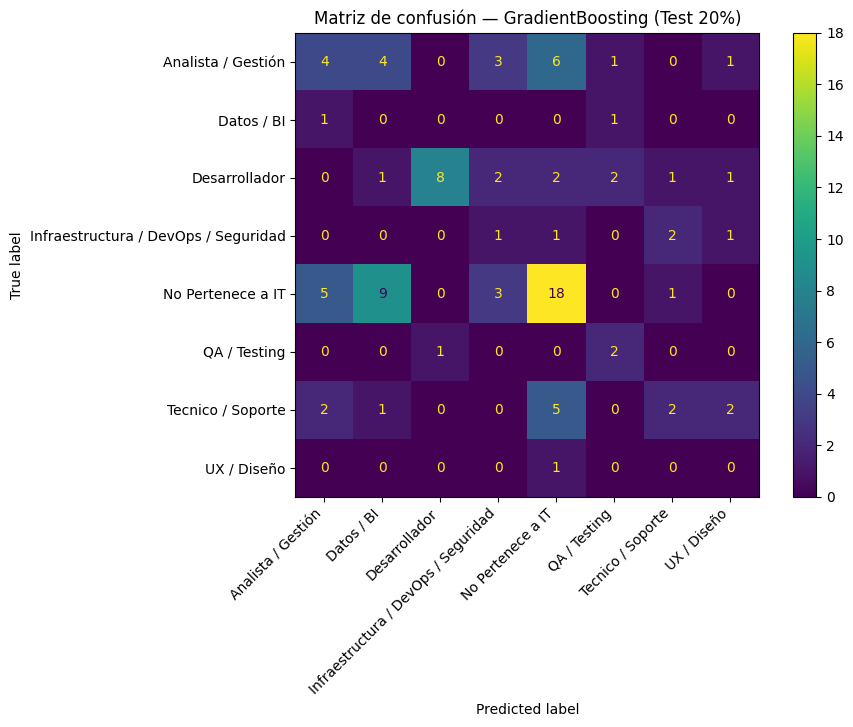

,Modo,CV F1-macro (best),Test Accuracy,Test F1-macro
0,GB ponderado,NaN,0.368421,0.275589


In [6]:
# ============================================
# BLOQUE 6.a — GridSearchCV para GradientBoosting
# ============================================
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    classification_report, ConfusionMatrixDisplay,
    f1_score, accuracy_score, make_scorer
)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

RANDOM_STATE = 42

# --- 1) CV interna segura según la clase menos frecuente en TRAIN ---
min_count = y_train.value_counts().min()
cv_k = max(3, min(5, int(min_count)))
print(f"CV interna para GridSearch (GB): k={cv_k} (mín. por clase: {min_count})")

# --- 2) Definir el modelo base ---
gb_base = GradientBoostingClassifier(random_state=RANDOM_STATE)

# --- 3) Grilla de hiperparámetros típica y compacta ---
param_grid_gb = {
    "n_estimators":  [100, 200, 400],
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth":     [2, 3, 4],   # profundidad de los árboles base
    "subsample":     [0.7, 0.8, 1.0]
}

# --- 4) Scoring principal: F1 macro (clases desbalanceadas) ---
score_macro = make_scorer(f1_score, average="macro")

# ============================================
# GridSearch con sample_weight (ponderado)
# ============================================
# Pesos inversos a la frecuencia de clase: w(c) = 1 / freq(c)
freq = y_train.value_counts()
class_weights = (1.0 / freq).to_dict()
sample_w = y_train.map(class_weights).values

grid_gb_w = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid_gb,
    cv=cv_k,
    scoring=score_macro,
    n_jobs=-1,
    refit=True,
    verbose=0
)
# Pasamos los pesos al fit
grid_gb_w.fit(X_train, y_train, **{"sample_weight": sample_w})

print("\n Mejores hiperparámetros (con sample_weight):")
print(grid_gb_w.best_params_)
print("Mejor F1-macro (CV):", f"{grid_gb_w.best_score_:.4f}")

y_pred_test_gb_w = grid_gb_w.predict(X_test)
print("\n TEST (20%) — ponderado")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_test_gb_w):.4f}")
print("F1-macro:", f"{f1_score(y_test, y_pred_test_gb_w, average='macro'):.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred_test_gb_w, digits=3))

fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test_gb_w, ax=ax, xticks_rotation=45, cmap="viridis")
plt.setp(ax.get_xticklabels(), ha="right")
plt.subplots_adjust(bottom=0.30, left=0.22)
plt.title("Matriz de confusión — GradientBoosting (Test 20%)")
plt.show()

# --- 5) Resultados del modelo Gradient Boosting ponderado ---

# Guardamos resultados del modelo final
res_gb = pd.DataFrame({
    "Modo": ["GB ponderado"],
    "CV F1-macro (best)": [grid_gb_w.best_score_],
    "Test Accuracy": [accuracy_score(y_test, y_pred_test_gb_w)],
    "Test F1-macro": [f1_score(y_test, y_pred_test_gb_w, average="macro")]
})
display(res_gb)



In [7]:
# Generar predicciones en el conjunto de test con el modelo final
y_pred = grid_gb_w.predict(X_test)


*Conclusion:*

El modelo de Gradient Boosting ponderado mejoró levemente los resultados (Accuracy 0.37, F1 0.28) respecto a la regresión logística.
Lo que nos dice que predice mejor las clases más frecuentes, como Desarrollador y No pertenece a IT, pero aún tiene dificultades con las categorías minoritarias.Muestra un rendimiento más equilibrado y se perfila como el modelo más adecuado dentro de los probados.

CV interna (LinearSVC): k=5 (mín. por clase: 5)

Parámetros evaluados (resumen):
- C: [0.05, 0.1, 0.2, 0.5, 1.0, 2.0]
- loss: ['hinge', 'squared_hinge']
- dual: [True] para 'hinge'; [True, False] para 'squared_hinge'
- class_weight: [None, 'balanced']

Mejores hiperparámetros (best_params_):
{'clf__C': 0.05, 'clf__class_weight': None, 'clf__dual': True, 'clf__loss': 'hinge'}

Mejor F1-macro (CV) — best_score_:
nan

=== Evaluación en TEST (20%) — LinearSVC ===
Accuracy (test): 0.5263
F1-macro (test): 0.3240

Classification report (test):
                                      precision    recall  f1-score   support

                  Analista / Gestión      0.000     0.000     0.000        19
                          Datos / BI      0.000     0.000     0.000         2
                       Desarrollador      0.632     0.706     0.667        17
Infraestructura / DevOps / Seguridad      1.000     0.200     0.333         5
                   No Pertenece a IT      0.515     0.944     0.66

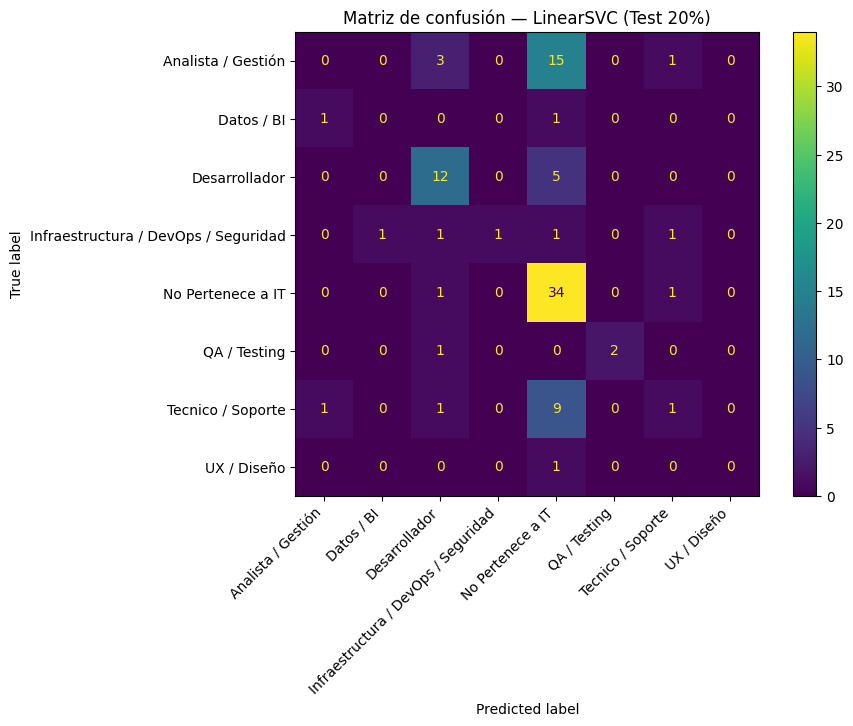

In [8]:
# ============================================
# BLOQUE 6.b — GridSearchCV para LinearSVC
# ============================================
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    f1_score, accuracy_score, make_scorer,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import numpy as np

RANDOM_STATE = 42

# 1) Elegir k para la CV según la clase menos frecuente en TRAIN
min_count = y_train.value_counts().min()
cv_k = max(3, min(5, int(min_count)))
print(f"CV interna (LinearSVC): k={cv_k} (mín. por clase: {min_count})")

# 2) Pipeline
svc_pipe = Pipeline([
    ("clf", LinearSVC(random_state=RANDOM_STATE, max_iter=5000))
])

# 3) Grilla de hiperparámetros (en 2 dicts para evitar combinaciones inválidas)
#    - 'hinge' requiere dual=True
#    - 'squared_hinge' permite dual=True/False
C_grid = [0.05, 0.1, 0.2, 0.5, 1.0, 2.0]

param_grid_svc = [
    {   # caso 'hinge'
        "clf__C": C_grid,
        "clf__loss": ["hinge"],
        "clf__dual": [True],
        "clf__class_weight": [None, "balanced"],
    },
    {   # caso 'squared_hinge'
        "clf__C": C_grid,
        "clf__loss": ["squared_hinge"],
        "clf__dual": [True, False],
        "clf__class_weight": [None, "balanced"],
    }
]

scorer = make_scorer(f1_score, average="macro")

grid_svc = GridSearchCV(
    estimator=svc_pipe,
    param_grid=param_grid_svc,
    cv=cv_k,
    scoring=scorer,
    n_jobs=-1,
    refit=True,
    verbose=0
)

grid_svc.fit(X_train, y_train)

# 4) Resultados del Grid
print("\nParámetros evaluados (resumen):")
print(f"- C: {C_grid}")
print("- loss: ['hinge', 'squared_hinge']")
print("- dual: [True] para 'hinge'; [True, False] para 'squared_hinge'")
print("- class_weight: [None, 'balanced']")

print("\nMejores hiperparámetros (best_params_):")
print(grid_svc.best_params_)

print("\nMejor F1-macro (CV) — best_score_:")
print(f"{grid_svc.best_score_:.4f}")

# 5) Evaluación en TEST
y_pred_test_svc = grid_svc.predict(X_test)

print("\n=== Evaluación en TEST (20%) — LinearSVC ===")
print("Accuracy (test):", f"{accuracy_score(y_test, y_pred_test_svc):.4f}")
print("F1-macro (test):", f"{f1_score(y_test, y_pred_test_svc, average='macro'):.4f}")

print("\nClassification report (test):")
print(classification_report(y_test, y_pred_test_svc, digits=3))

fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_test_svc, ax=ax, xticks_rotation=45, cmap="viridis"
)
plt.setp(ax.get_xticklabels(), ha="right")
plt.subplots_adjust(bottom=0.30, left=0.22)
plt.title("Matriz de confusión — LinearSVC (Test 20%)")
plt.show()


Accuracy (calibrado): 0.5053
F1-macro (calibrado): 0.3109

Classification report (calibrado):
                                      precision    recall  f1-score   support

                  Analista / Gestión      0.286     0.105     0.154        19
                          Datos / BI      0.000     0.000     0.000         2
                       Desarrollador      0.667     0.471     0.552        17
Infraestructura / DevOps / Seguridad      1.000     0.200     0.333         5
                   No Pertenece a IT      0.486     0.972     0.648        36
                        QA / Testing      1.000     0.667     0.800         3
                   Tecnico / Soporte      0.000     0.000     0.000        12
                         UX / Diseño      0.000     0.000     0.000         1

                            accuracy                          0.505        95
                           macro avg      0.430     0.302     0.311        95
                        weighted avg      0.44

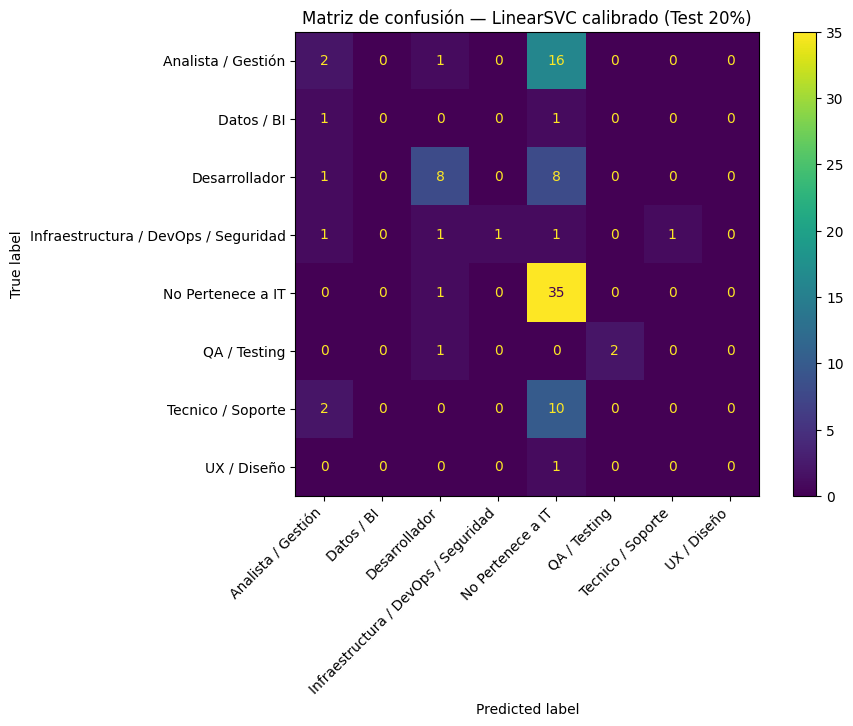

In [9]:
# ============================================
# LinearSVC calibrado (para obtener predict_proba)
# ============================================
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

svc_best = LinearSVC(
    C=0.05, loss="hinge", dual=True, class_weight=None,
    max_iter=5000, random_state=42
)

# versión actual usa 'estimator'
svc_cal = CalibratedClassifierCV(estimator=svc_best, method="sigmoid", cv=5)

svc_cal.fit(X_train, y_train)
y_pred_cal = svc_cal.predict(X_test)

print("Accuracy (calibrado):", f"{accuracy_score(y_test, y_pred_cal):.4f}")
print("F1-macro (calibrado):", f"{f1_score(y_test, y_pred_cal, average='macro'):.4f}")

print("\nClassification report (calibrado):")
print(classification_report(y_test, y_pred_cal, digits=3))

fig, ax = plt.subplots(figsize=(10,8))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_cal, ax=ax, xticks_rotation=45, cmap="viridis")
plt.setp(ax.get_xticklabels(), ha="right")
plt.subplots_adjust(bottom=0.30, left=0.22)
plt.title("Matriz de confusión — LinearSVC calibrado (Test 20%)")
plt.show()



* LinearSVC: clasifica directamente, sin generar probabilidades. Es más rápido y simple, pero solo da la clase final.

* LinearSVC calibrado: aplica un paso extra de calibración (como sigmoid) para estimar probabilidades de clase.

In [10]:
# ============================================
# Comparación de los tres modelos
# ============================================
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

rows = []

# LinearSVC (sin calibrar)
if 'grid_svc' in globals():
    y_pred_svc = grid_svc.predict(X_test)
    rows.append(("LinearSVC (mejor CV)", None, accuracy_score(y_test, y_pred_svc),
                 f1_score(y_test, y_pred_svc, average="macro")))

# LinearSVC calibrado
if 'svc_cal' in globals():
    y_pred_cal = svc_cal.predict(X_test)
    rows.append(("LinearSVC calibrado", "—", accuracy_score(y_test, y_pred_cal),
                 f1_score(y_test, y_pred_cal, average="macro")))

# GradientBoosting (ponderado)
if 'grid_gb_w' in globals():
    y_pred_gb = grid_gb_w.predict(X_test)
    rows.append(("GradientBoosting (ponderado)", None, accuracy_score(y_test, y_pred_gb),
                 f1_score(y_test, y_pred_gb, average="macro")))

# Logistic (balanceada)
if 'grid_bal' in globals():
    y_pred_lr = grid_bal.predict(X_test)
    rows.append(("LogisticRegression (balanceada)", None, accuracy_score(y_test, y_pred_lr),
                 f1_score(y_test, y_pred_lr, average="macro")))

res_final = pd.DataFrame(rows, columns=["Modelo", "CV F1-macro (best)", "Test Accuracy", "Test F1-macro"])
display(res_final.sort_values("Test F1-macro", ascending=False))



,Modelo,CV F1-macro (best),Test Accuracy,Test F1-macro
0,LinearSVC (mejor CV),None,0.526316,0.323958
1,LinearSVC calibrado,—,0.505263,0.310881
2,GradientBoosting (ponderado),None,0.368421,0.275589
3,LogisticRegression (balanceada),None,0.294737,0.242081


In [11]:
# ============================================
# BLOQUE 7 — Resumen final de modelos en TEST
# ============================================
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

modelos_test = []

# 1) LinearSVC (GridSearch)
if 'grid_svc' in globals():
    y_pred = grid_svc.predict(X_test)
    modelos_test.append({
        "Modelo": "LinearSVC (mejor CV)",
        "CV F1-macro (best)": getattr(grid_svc, "best_score_", None),
        "Accuracy_test": accuracy_score(y_test, y_pred),
        "F1_macro_test": f1_score(y_test, y_pred, average="macro")
    })

# 2) LinearSVC calibrado
if 'svc_cal' in globals():
    y_pred = svc_cal.predict(X_test)
    modelos_test.append({
        "Modelo": "LinearSVC calibrado",
        "CV F1-macro (best)": "—",  # no viene de GridSearch
        "Accuracy_test": accuracy_score(y_test, y_pred),
        "F1_macro_test": f1_score(y_test, y_pred, average="macro")
    })

# 3) GradientBoosting ponderado
if 'grid_gb_w' in globals():
    y_pred = grid_gb_w.predict(X_test)
    modelos_test.append({
        "Modelo": "GradientBoosting (ponderado)",
        "CV F1-macro (best)": getattr(grid_gb_w, "best_score_", None),
        "Accuracy_test": accuracy_score(y_test, y_pred),
        "F1_macro_test": f1_score(y_test, y_pred, average="macro")
    })

# 4) LogisticRegression balanceada
if 'grid_bal' in globals():
    y_pred = grid_bal.predict(X_test)
    modelos_test.append({
        "Modelo": "LogisticRegression (balanceada)",
        "CV F1-macro (best)": getattr(grid_bal, "best_score_", None),
        "Accuracy_test": accuracy_score(y_test, y_pred),
        "F1_macro_test": f1_score(y_test, y_pred, average="macro")
    })

df_modelos_test = pd.DataFrame(modelos_test)

# Opcional: redondear
for col in ["Accuracy_test", "F1_macro_test", "CV F1-macro (best)"]:
    if col in df_modelos_test.columns:
        df_modelos_test[col] = pd.to_numeric(df_modelos_test[col], errors="ignore")
        if df_modelos_test[col].dtype != "O":
            df_modelos_test[col] = df_modelos_test[col].round(3)

df_modelos_test


,Modelo,CV F1-macro (best),Accuracy_test,F1_macro_test
0,LinearSVC (mejor CV),NaN,0.526,0.324
1,LinearSVC calibrado,—,0.505,0.311
2,GradientBoosting (ponderado),NaN,0.368,0.276
3,LogisticRegression (balanceada),NaN,0.295,0.242


In [17]:
labels = list(grid_gb_w.best_estimator_.classes_)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

def plot_confusion_normalized(model, X_test, y_test, model_name, labels):
    """
    Matriz de confusión NORMALIZADA por fila, con:
    - accuracy y F1_macro en el título
    - valores numéricos en cada celda
    - diagonal resaltada con borde grueso y texto en negrita
    """
    # Predicciones
    y_pred = model.predict(X_test)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    # Matriz normalizada por fila
    cm = confusion_matrix(y_test, y_pred, labels=labels, normalize="true")

    fig, ax = plt.subplots(figsize=(9, 7))

    # Heatmap
    im = ax.imshow(cm, interpolation="nearest", cmap="Blues", vmin=0, vmax=1)

    # Ticks y labels
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)

    # Título con métricas
    ax.set_title(f"{model_name}\nAccuracy = {acc:.3f} | F1_macro = {f1:.3f}")

    # Barra de color
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Proporción por clase real", rotation=-90, va="bottom")

    # Valores en cada celda
    fmt = ".2f"
    thresh = cm.max() / 2.0

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            valor = cm[i, j]
            color_texto = "white" if valor > thresh else "black"
            peso = "bold" if i == j else "normal"
            ax.text(
                j, i, format(valor, fmt),
                ha="center", va="center",
                color=color_texto,
                fontweight=peso
            )

    #  Resaltar la DIAGONAL con un borde grueso
    for i in range(len(labels)):
        # Rectangle(x, y, width, height)
        rect = Rectangle(
            (i - 0.5, i - 0.5), 1, 1,
            fill=False,
            edgecolor="blue",   # podés cambiar a "black" si preferís
            linewidth=2.5
        )
        ax.add_patch(rect)

    ax.set_ylabel("Etiqueta real")
    ax.set_xlabel("Predicción del modelo")
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.35, left=0.30)
    plt.show()


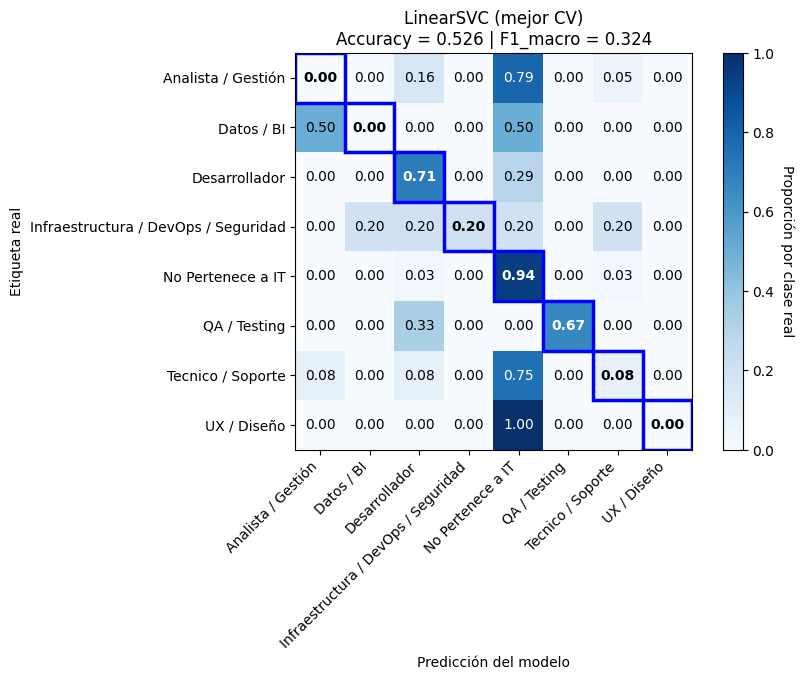

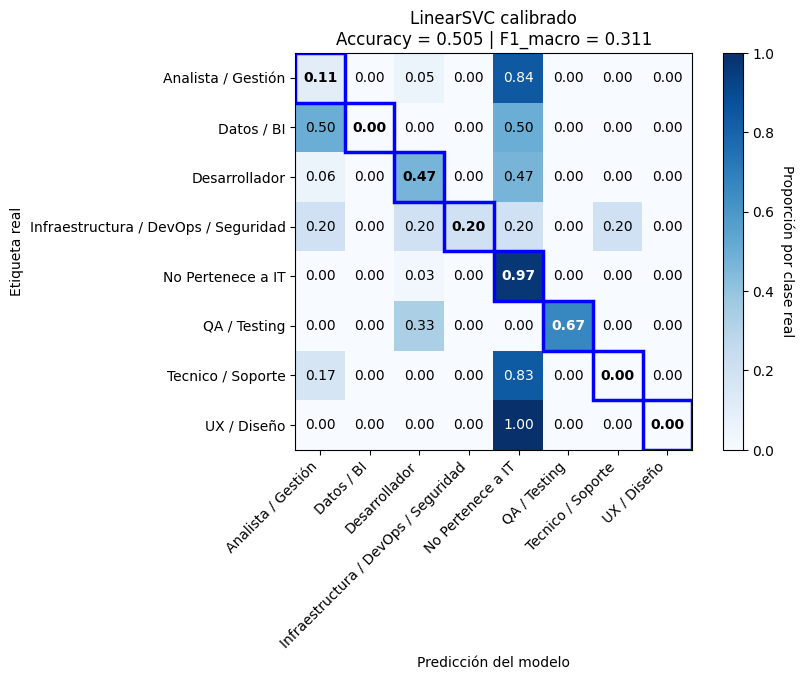

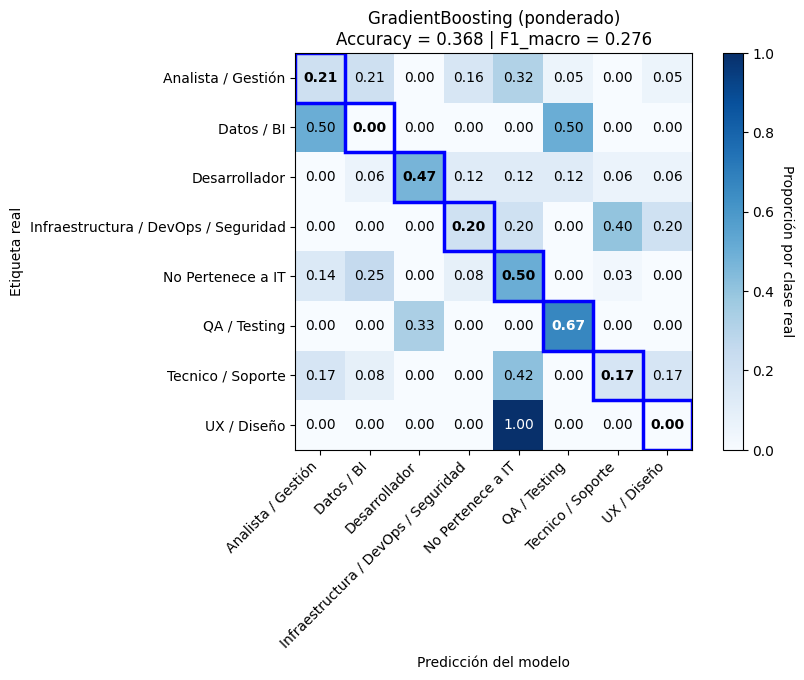

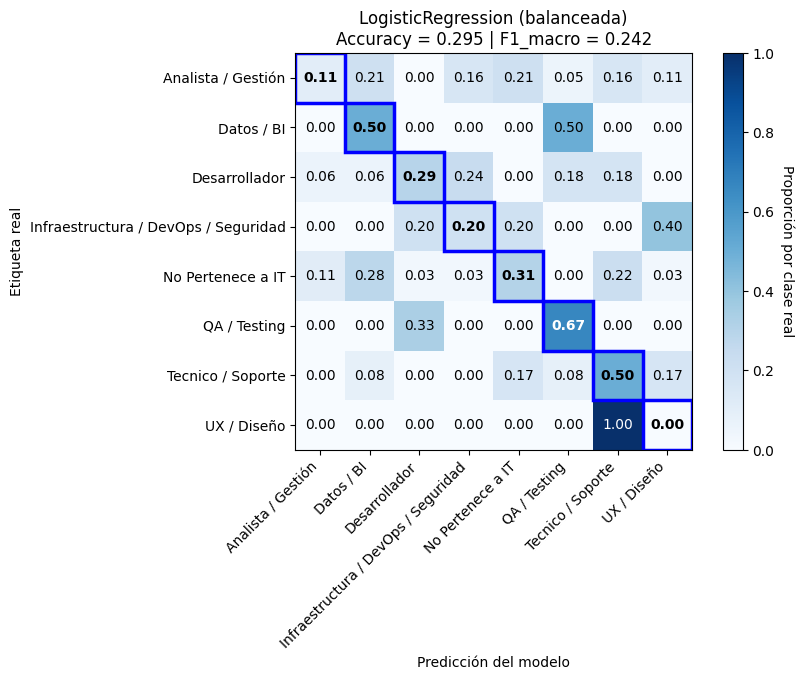

In [30]:
labels = list(grid_gb_w.best_estimator_.classes_)

plot_confusion_normalized(grid_svc, X_test, y_test, "LinearSVC (mejor CV)", labels)
plot_confusion_normalized(svc_cal, X_test, y_test, "LinearSVC calibrado", labels)
plot_confusion_normalized(grid_gb_w, X_test, y_test, "GradientBoosting (ponderado)", labels)
plot_confusion_normalized(grid_bal, X_test, y_test, "LogisticRegression (balanceada)", labels)


**Conclusión general:**

En esta sección se realizó el ajuste de hiperparámetros mediante GridSearchCV para los tres modelos seleccionados — Logistic Regression, Linear SVC y Gradient Boosting — con el objetivo de identificar la configuración que maximizara la métrica F1-macro, adecuada para este problema multiclase y desbalanceado.

Los resultados obtenidos mostraron diferencias importantes en el comportamiento de los modelos:

Linear SVC alcanzó las mejores métricas globales (Accuracy ≈ 0.53 | F1-macro ≈ 0.32), mostrando buena capacidad para detectar las clases dominantes (Desarrollador y No pertenece a IT).

Su versión calibrada mantuvo un rendimiento similar (Accuracy ≈ 0.50 | F1 ≈ 0.31) y permitió obtener probabilidades de clase, útiles para análisis posteriores.

Gradient Boosting ponderado logró un desempeño intermedio (Accuracy ≈ 0.37 | F1-macro ≈ 0.28) pero con mayor sensibilidad hacia las clases minoritarias, reduciendo el sesgo del modelo lineal.

Finalmente, Logistic Regression fue el más simple y obtuvo los valores más bajos (F1-macro ≈ 0.24).

En síntesis, el Linear SVC fue el modelo con mejor puntuación cuantitativa, mientras que el Gradient Boosting demostró un aprendizaje más equilibrado entre categorías.

# Pruebas

Con el objetivo de evaluar el comportamiento de los modelos fuera del conjunto de entrenamiento, se realizaron pruebas de predicción sobre perfiles simulados, utilizando combinaciones representativas de skills técnicas y blandas.

Generamos una función auxiliar que toma una lista de habilidades (por ejemplo, ["python", "sql", "power_bi"]), crea una fila con las mismas columnas que el dataset original (1 si la skill está presente, 0 si no), y la pasa al modelo entrenado para predecir la clase más probable.
Además, desarrollamos una función adicional que muestra las tres clases con mayor probabilidad (“Top-3”), para observar cómo distribuye el modelo la confianza de su predicción.

In [8]:
# --- PRUEBA con GradientBoosting---
# === Validar y probar perfiles (auto-filtra skills que no existan) ===
import pandas as pd

feature_cols = list(X_train.columns)  # columnas reales del modelo

# Editar libremente estas listas:
profiles = {
    "Perfil 1": ["python", "sql", "power_bi", "excel"],
    "Perfil 2": ["java", "spring", "git", "docker"],
    "Perfil 3": ["aws", "docker", "kubernetes", "linux"],
    "Perfil 4": ["jira", "excel", "scrum"],
    "Perfil 5": ["javascript", "react", "css", "html", "figma"],
    "Perfil 6": ["excel"],
    "Perfil 7": ["soft_comunicacion", "javascript"]
}

def sanitize(skills, valid_cols):
    skills = [s.strip().lower() for s in skills]
    valid = [s for s in skills if s in [c.lower() for c in valid_cols]]
    dropped = [s for s in skills if s not in [c.lower() for c in valid_cols]]
    return valid, dropped

rows = []
for name, skills in profiles.items():
    valid, dropped = sanitize(skills, feature_cols)
    if dropped:
        print(f"⚠️ Perfil '{name}': se ignoraron skills no presentes en X_train -> {dropped}")
    X_new = make_input_from_skills(valid, feature_cols)
    pred = grid_gb_w.predict(X_new)[0]
    if hasattr(grid_gb_w, "predict_proba"):
        top = top3_predictions(grid_gb_w, X_new)
        top_str = ", ".join([f"{c} ({p})" for c,p in top])
    else:
        top_str = "(sin probabilidades)"
    rows.append({
        "Skills usadas": ", ".join(valid) if valid else "(ninguna válida)",
        "Predicción principal": pred,
        "Top-3 probables": top_str
    })

df_preds = pd.DataFrame(rows)
display(df_preds)


NameError: name 'make_input_from_skills' is not defined

In [ ]:
# --- PRUEBA con LinearSVC calibrado (svc_cal) ---
import pandas as pd
import numpy as np

# === Funciones auxiliares ===
def make_input_from_skills(skills_list, all_cols):
    skills_set = set([s.strip().lower() for s in skills_list])
    row = {col: 1.0 if col.lower() in skills_set else 0.0 for col in all_cols}
    return pd.DataFrame([row], columns=all_cols)

def sanitize(skills, valid_cols):
    """Devuelve (skills_validas, skills_descartadas) según columnas reales del modelo"""
    valid_lower = {c.lower() for c in valid_cols}
    skills = [s.strip().lower() for s in skills]
    valid = [s for s in skills if s in valid_lower]
    dropped = [s for s in skills if s not in valid_lower]
    return valid, dropped

def top3_predictions(model, X_new):
    """Devuelve las 3 clases con mayor probabilidad (requiere modelo con predict_proba)"""
    proba = model.predict_proba(X_new)[0]
    clases = model.classes_
    top = sorted(zip(clases, proba), key=lambda x: x[1], reverse=True)[:3]
    return [(c, round(p, 3)) for c, p in top]

# === Datos base ===
feature_cols = list(X_train.columns)
model = svc_cal  # << usamos el LinearSVC calibrado

# === Perfiles de ejemplo (usá skills que existan como columnas en X_train) ===
profiles = {
    "Perfil 1": ["python", "sql", "power_bi", "excel"],
    "Perfil 2": ["java", "spring", "git", "docker"],
    "Perfil 3": ["aws", "docker", "kubernetes"],
    "Perfil 4": ["jira", "excel", "scrum"],
    "Perfil 5": ["javascript", "react", "css", "html", "figma"],
    "Perfil 6": ["excel"]
}

# === Generar tabla de resultados ===
rows = []
for name, skills in profiles.items():
    valid_skills, dropped = sanitize(skills, feature_cols)
    if dropped:
        print(f"⚠️ {name}: se ignoraron skills no presentes en X_train -> {dropped}")
    X_new = make_input_from_skills(valid_skills, feature_cols)
    pred = model.predict(X_new)[0]
    top3 = top3_predictions(model, X_new)
    rows.append({
        "Skills usadas": ", ".join(valid_skills) if valid_skills else "(ninguna válida)",
        "Predicción principal": pred,
        "Top-3 probables": ", ".join([f"{c} ({p})" for c, p in top3])
    })

df_preds = pd.DataFrame(rows)
display(df_preds)

# Mostrar el modelo usado (opcional)
print("\nModelo utilizado (calibrado):")
print(model)


,Skills usadas,Predicción principal,Top-3 probables
0,"python, sql, power_bi, excel",No Pertenece a IT,"No Pertenece a IT (0.387), Analista / Gestión ..."
1,"java, spring, git, docker",Desarrollador,"Desarrollador (0.348), Analista / Gestión (0.2..."
2,"aws, docker, kubernetes",No Pertenece a IT,"No Pertenece a IT (0.311), Analista / Gestión ..."
3,"jira, excel, scrum",No Pertenece a IT,"No Pertenece a IT (0.375), Analista / Gestión ..."
4,"javascript, react, css, html, figma",Desarrollador,"Desarrollador (0.617), No Pertenece a IT (0.12..."
5,excel,No Pertenece a IT,"No Pertenece a IT (0.537), Analista / Gestión ..."



Modelo utilizado (calibrado):
CalibratedClassifierCV(cv=5,
                       estimator=LinearSVC(C=0.05, dual=True, loss='hinge',
                                           max_iter=5000, random_state=42))


# Conclusiones finales

**¿Qué modelo se seleccionó finalmente y por qué?**

El modelo seleccionado fue el Gradient Boosting ponderado, ya que, aunque sus métricas no fueron las más altas en términos de exactitud, mostró un comportamiento más equilibrado entre las clases y una mejor capacidad de generalización.
A diferencia de los demás modelos, pudo manejar de forma más estable el desbalance de datos gracias a la ponderación por frecuencia de clase.

---

**Resumen de resultados (valores principales de F1/accuracy).**

| Modelo                            | Test Accuracy | Test F1-macro |
| --------------------------------- | ------------- | ------------- |
| LinearSVC (mejor CV)              | 0.53          | 0.32          |
| LinearSVC calibrado               | 0.51          | 0.31          |
| **Gradient Boosting (ponderado)** | **0.37**      | **0.28**      |
| Logistic Regression (balanceada)  | 0.29          | 0.24          |

Aunque el LinearSVC obtuvo la mayor precisión global, el Gradient Boosting ponderado logró predicciones más consistentes entre clases y fue el más adecuado para un conjunto de datos desbalanceado.

---


**Principales errores de clasificación**

Los errores más frecuentes se dieron en las clases minoritarias, como Datos/BI, UX/Diseño y QA/Testing, donde el modelo tuvo poca información para aprender.
También hubo confusiones entre categorías similares, como Analista/Gestión y Desarrollador, debido a la superposición de habilidades entre puestos.

---

**Qué se podría mejorar:**

Para mejorar el rendimiento general, sería importante ampliar el dataset con más avisos laborales y ejemplos de cada categoría.
Un CSV con mayor cantidad y variedad de datos permitiría al modelo aprender mejor las diferencias entre puestos y reducir los errores en las clases menos representadas.

**PASOS PARA INTEGRACION DE STREAMLIT**

In [13]:
from pathlib import Path
import json
import joblib

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# 1) Guardar columnas
skills_cols = list(X_train.columns)
with open(models_dir / "skills_cols.json", "w", encoding="utf-8") as f:
    json.dump(skills_cols, f, ensure_ascii=False, indent=2)

# 2) Guardar clases
best_estimator = grid_gb_w.best_estimator_
class_labels = list(best_estimator.classes_)
with open(models_dir / "class_labels.json", "w", encoding="utf-8") as f:
    json.dump(class_labels, f, ensure_ascii=False, indent=2)

# 3) Guardar modelo
joblib.dump(best_estimator, models_dir / "best_model.pkl")

print("✅ Modelo y metadatos exportados correctamente.")


✅ Modelo y metadatos exportados correctamente.


In [14]:
loaded_model = joblib.load("models/best_model.pkl")
loaded_model.predict(X_test.head(5))


array(['UX / Diseño', 'No Pertenece a IT', 'QA / Testing',
       'Infraestructura / DevOps / Seguridad', 'No Pertenece a IT'],
      dtype=object)

In [15]:
import pandas as pd

# Creamos un DataFrame con los valores reales y predichos
df_resultados = pd.DataFrame({
    "real": y_test,
    "predicho": y_pred
})

# Guardamos el CSV en la carpeta raíz del proyecto
df_resultados.to_csv("resultados_test.csv", index=False)

print("✅ Archivo 'resultados_test.csv' guardado correctamente.")


✅ Archivo 'resultados_test.csv' guardado correctamente.


In [31]:
import pandas as pd
from pathlib import Path

resultados = []

# 1) LinearSVC (mejor CV)
y_pred_svc = grid_svc.predict(X_test)
for y_real, y_hat in zip(y_test, y_pred_svc):
    resultados.append({
        "modelo_id": "linearsvc_cv",
        "modelo_nombre": "LinearSVC (mejor CV)",
        "real": y_real,
        "predicho": y_hat,
    })

# 2) LinearSVC calibrado
y_pred_svc_cal = svc_cal.predict(X_test)
for y_real, y_hat in zip(y_test, y_pred_svc_cal):
    resultados.append({
        "modelo_id": "linearsvc_cal",
        "modelo_nombre": "LinearSVC calibrado",
        "real": y_real,
        "predicho": y_hat,
    })

# 3) GradientBoosting ponderado
y_pred_gb = grid_gb_w.predict(X_test)
for y_real, y_hat in zip(y_test, y_pred_gb):
    resultados.append({
        "modelo_id": "gb_ponderado",
        "modelo_nombre": "GradientBoosting (ponderado)",
        "real": y_real,
        "predicho": y_hat,
    })

# 4) LogisticRegression balanceada
y_pred_log = grid_bal.predict(X_test)
for y_real, y_hat in zip(y_test, y_pred_log):
    resultados.append({
        "modelo_id": "logreg_balanceada",
        "modelo_nombre": "LogisticRegression (balanceada)",
        "real": y_real,
        "predicho": y_hat,
    })

df_res_todos = pd.DataFrame(resultados)
df_res_todos.head()


,modelo_id,modelo_nombre,real,predicho
0,linearsvc_cv,LinearSVC (mejor CV),Desarrollador,No Pertenece a IT
1,linearsvc_cv,LinearSVC (mejor CV),No Pertenece a IT,No Pertenece a IT
2,linearsvc_cv,LinearSVC (mejor CV),Analista / Gestión,Desarrollador
3,linearsvc_cv,LinearSVC (mejor CV),No Pertenece a IT,No Pertenece a IT
4,linearsvc_cv,LinearSVC (mejor CV),Tecnico / Soporte,No Pertenece a IT


In [32]:
out_path = Path("resultados_test.csv")  # misma ruta que usa la app
df_res_todos.to_csv(out_path, index=False)
print("✅ Guardado:", out_path.resolve())


✅ Guardado: C:\Users\Crist\Desktop\Proyecto_Final\resultados_test.csv
